ANGGOTA KELOMPOK

1. 19090036 - Muhamad Zaim zamzami
2. 19090039 - Fatimatuzzahro

In [ ]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D, Flatten, Dropout, MaxPooling2D
from keras.applications.mobilenet import preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
# Setup Kaggle environment
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d hilmiher/face-disease

 95% 275M/290M [00:02<00:00, 121MB/s]
100% 290M/290M [00:02<00:00, 131MB/s]


In [ ]:
import zipfile
local_zip = 'face-disease.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/face-disease/')
zip_ref.close()

In [ ]:
!rm face-disease.zip
!rm -r {"/content/face-disease/test/eksim"}
!rm -r {"/content/face-disease/test/herpes"}
!rm -r {"/content/face-disease/test/milia"}
!rm -r {"/content/face-disease/test/panu"}
!rm -r {"/content/face-disease/test/blackhead"}
!rm -r {"/content/face-disease/test/tineafasialis"}
!rm -r {"/content/face-disease/train/eksim"}
!rm -r {"/content/face-disease/train/herpes"}
!rm -r {"/content/face-disease/train/milia"}
!rm -r {"/content/face-disease/train/panu"}
!rm -r {"/content/face-disease/train/blackhead"}
!rm -r {"/content/face-disease/train/tineafasialis"}
!rm -r {"/content/face-disease/validation/eksim"}
!rm -r {"/content/face-disease/validation/herpes"}
!rm -r {"/content/face-disease/validation/milia"}
!rm -r {"/content/face-disease/validation/panu"}
!rm -r {"/content/face-disease/validation/blackhead"}
!rm -r {"/content/face-disease/validation/tineafasialis"}

In [ ]:
train_dir = '/content/face-disease/train'
valid_dir = '/content/face-disease/validation'

In [ ]:
base_model=MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

last_layer = base_model.get_layer('block_16_project_BN')
last_output = last_layer.output

x=GlobalAveragePooling2D()(last_output)
x=Dense(64,activation='relu')(x) #dense layer 2
x=Dropout(0.3)(x)
x=Dense(64,activation='relu')(x) #dense layer 3
x=Dropout(0.3)(x)
x=Dense(3,activation='softmax')(x) 

model = Model(base_model.input, x)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary() 
for layer in base_model.layers:
    layer.trainable=False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    height_shift_range=0.2,
    shear_range=0.2,
    validation_split=0.2
) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./face-disease/train',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)
val_generator=train_datagen.flow_from_directory('./face-disease/validation',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True,)


Found 470 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        loss = logs["val_loss"]
        if accuracy >= self.threshold and loss <= self.threshold:
            self.model.stop_training = True

In [ ]:
xcallback=MyThresholdCallback(threshold=0.9)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_generator,
          epochs=20,
          validation_data=val_generator)

Epoch 1/20
8/8 [==============================] - 37s 4s/step - loss: 1.1012 - accuracy: 0.5128 - val_loss: 0.9979 - val_accuracy: 0.5380
Epoch 2/20
8/8 [==============================] - 28s 4s/step - loss: 0.7172 - accuracy: 0.6957 - val_loss: 0.7918 - val_accuracy: 0.6784
Epoch 3/20
8/8 [==============================] - 30s 4s/step - loss: 0.6073 - accuracy: 0.7574 - val_loss: 0.8503 - val_accuracy: 0.6959
Epoch 4/20
8/8 [==============================] - 30s 4s/step - loss: 0.5420 - accuracy: 0.7851 - val_loss: 0.8477 - val_accuracy: 0.7018
Epoch 5/20
8/8 [==============================] - 27s 3s/step - loss: 0.4940 - accuracy: 0.7915 - val_loss: 0.8285 - val_accuracy: 0.7251
Epoch 6/20
8/8 [==============================] - 31s 4s/step - loss: 0.4404 - accuracy: 0.8191 - val_loss: 0.6407 - val_accuracy: 0.7778
Epoch 7/20
8/8 [==============================] - 28s 3s/step - loss: 0.4077 - accuracy: 0.8489 - val_loss: 0.7991 - val_accuracy: 0.7427
Epoch 8/20
8/8 [==================

In [ ]:
model.evaluate(val_generator)

3/3 [==============================] - 7s 2s/step - loss: 0.6103 - accuracy: 0.8129


[0.6103332042694092, 0.8128654956817627]

In [ ]:
model.evaluate(train_generator)

8/8 [==============================] - 27s 3s/step - loss: 0.1101 - accuracy: 0.9574


[0.11005248874425888, 0.957446813583374]

In [ ]:
test_generator=train_datagen.flow_from_directory('./face-disease/test/',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False,)

Found 25 images belonging to 3 classes.


In [ ]:
test_score = model.evaluate_generator(test_generator)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 96.00%
[INFO] Loss:  0.16954822838306427


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(os.listdir(train_dir))
number_label = {}
total_files = 0
for i in os.listdir(train_dir):
    counting = len(os.listdir(os.path.join(train_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

['jerawat', 'flek hitam', 'rosacea']
Total Files : 470


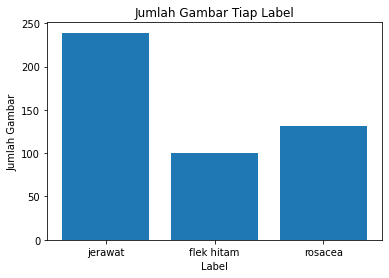

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

In [ ]:
classes = list(number_label.keys())

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


Confusion Matrix
[[ 4  0  0]
 [ 1  9  1]
 [ 0  0 10]]
Classification Report
              precision    recall  f1-score   support

  flek hitam       0.80      1.00      0.89         4
     jerawat       1.00      0.82      0.90        11
     rosacea       0.91      1.00      0.95        10

    accuracy                           0.92        25
   macro avg       0.90      0.94      0.91        25
weighted avg       0.93      0.92      0.92        25



In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = '/content/face-disease/test/rosacea/rosacea-56.jpg'
new_image = load_image(img_path)

pred = model.predict(new_image)

pred = np.argmax(pred, axis=1)

pred

array([2])

In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = '/content/face-disease/test/flek hitam/00000010.jpg'
new_image = load_image(img_path)

pred = model.predict(new_image)

pred = np.argmax(pred, axis=1)

pred

array([0])

In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = '/content/face-disease/test/jerawat/acne-cystic-38.jpg'
new_image = load_image(img_path)

pred = model.predict(new_image)

pred = np.argmax(pred, axis=1)

pred

array([1])

In [ ]:
import pathlib

model.save("model.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

# tflite_model_file = pathlib.Path("/content/tflite")
# tflite_model_file.write_bytes(tflite_model)

# Save the model.
with open('model_elequentv3.tflite', 'wb') as f:
  f.write(tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmpb0blmy1t/assets


INFO:tensorflow:Assets written to: /tmp/tmpb0blmy1t/assets
